#### Notes

In order to change the parameter `a` that controls how the sampler moves during its walk, you need to update the `emcee` package to the most recent version. To do this, run `pip install --upgrade emcee`.

Note that older notebooks will not work with this newer version, but any code that uses `fit2d` to run the MCMC will handle the version change. If you really need to run an older notebook (though it should be easy to port those parameters to a notebook based off this one) you can downgrade the version using `pip install emcee==2.2.1`.

This notebook, and any other code using `fit2d`, can run on the older version of emcee but you won't be able to change the move parameter. 

In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves


/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:

# number of bins in fit
num_bins = 3
# min and max bounds for each bin
vmin, vmax = 0., 200.


name = "UGC3974"
distance = 8000. # [kpc]
observed_2d_vel_field_fits_file = "/home/anna/Desktop/fit2d/data/UGC3974_1mom.fits"
deg_per_pixel=4.17e-4
v_systemic=270. 

ring_param_file = "/home/anna/Desktop/fit2d/data/UGC3974_ring_parameters.txt"
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 20
mcmc_niter = 4
mcmc_ndim = 1  # Do not change this if fitting one ring at a time
mcmc_nthreads = 4
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)  
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash
# Increase this; 2 is a very low value just for testing
batch_size = 2

# option to save outputs in a particular directory
save_dir = None  


### This is where you can provide a 2D array of pixel errors.
### Only one of these should be set- SET THE OTHER TO HAVE value `None`

In [3]:
# One, but not both, should be provided to lnlike

v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None

# to use the 2nd moment map,
# v_err_const = None
# v_err_2d = fits.open("/home/anna/Desktop/fit2d/data/UGC3974_2mom.fits")[0].data

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic, 
)

ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)
bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(num_bins)]

In [ ]:

for bin_index in range(num_bins):
    bin_min, bin_max = bin_edges[bin_index], bin_edges[bin_index+1]
    piecewise_model = PiecewiseModel(num_bins=1)
    piecewise_model.set_bounds(vmin, vmax)
    piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
    radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_min<r<bin_max])                              

    prior = LinearPrior(bounds=piecewise_model.bounds)
    prior_transform = prior.transform_from_unit_cube
    start_positions = piecewise_start_points(mcmc_nwalkers, piecewise_model.bounds, random_seed=random_seed)  
    fit_inputs = {
        "piecewise_model": piecewise_model,
        "galaxy": galaxy,
        "ring_model": ring_model,
        "prior_transform": prior_transform
    }
    
    print(f"Fitting ring {bin_index}")
    
    rotation_curve_func_kwargs = {
        "radii_to_interpolate": radii_to_interpolate}

    lnlike_args = [
        piecewise_model,
        rotation_curve_func_kwargs, 
        galaxy, 
        ring_model, 
        mask_sigma
    ]

    lnlike_args = {
        "model": piecewise_model,
        "rotation_curve_func_kwargs": rotation_curve_func_kwargs, 
        "galaxy": galaxy, 
        "ring_model": ring_model, 
        "mask_sigma": mask_sigma,
        "v_err_const": v_err_const,
        "v_err_2d": v_err_2d
        }

    sampler = EnsembleSampler(
        mcmc_nwalkers,
        mcmc_ndim, 
        emcee_lnlike, 
        args=[mcmc_version, lnlike_args], 
        threads=mcmc_nthreads,
    )
    if mcmc_version >= 3:
        sampler._moves = [mcmc_moves]

    sampler_output_file = os.path.join(
        save_dir or "", f"sampler_{galaxy.name}_ring{bin_index}_{bin_min:.2f}-{bin_max:.2f}.pkl")
    for batch in range(mcmc_niter // batch_size):
        if batch == 0:
            batch_start = start_positions
        else:
            batch_start = None
            sampler.pool = temp_pool
        sampler.run_mcmc(batch_start, batch_size)
        temp_pool = sampler.pool
        del sampler.pool
        with open(sampler_output_file, 'wb') as f:
            joblib.dump(sampler, f)
        print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_niter}")

print(f"Done with emcee fit for {galaxy.name}")

In [10]:
from fit2d.analysis.emcee import get_output_files, combine_results_statistics


# pass the galaxy name, if you specified a particular save directory provide it as argument dir
output_files = get_output_files(galaxy_name="UGC3974", dir=None)
mean, std = combine_results_statistics(
    output_files,
    min_iter=None,
    max_iter=None)

<ErrorbarContainer object of 3 artists>

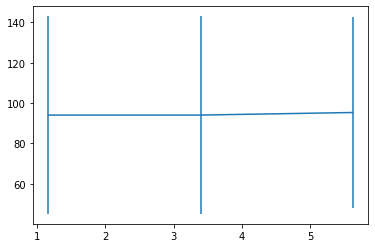

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.errorbar(bin_centers, mean, yerr=std)